# 甲状腺組織画像の識別に関する研究
## 画像識別プログラム

## ライブラリ読み込み，ランダムシード固定

In [1]:
import random
import itertools
import copy
import os
import glob

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split, Subset
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.models import resnet50, resnet18, resnet101, resnet152
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from PIL import Image
import scipy
import pandas as pd

%matplotlib inline

torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [2]:
torch.__version__

'1.6.0'

## subsetにtransformを適用するためのクラス
- Datasetクラスを継承
- subsetに直接transformを適用することはできない。
- subsetに前処理を適用したdatasetを返却する。

### Attributes
- subset(object):Subsetクラスのより分割されたdataset
- transform(object):前処理のクラスのインスタンス

In [3]:
class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.sub = subset
        self.transform = transform
        
    def __len__(self):
        return len(self.sub)
    
    def __getitem__(self, index):
        x, y = self.sub[index]
        if self.transform:
            x = self.transform(x)
        return x, y

### datasetを訓練用と検証用に分割する関数
#### Parameters
- dataset(object):データセットのインスタンス
- train_indices(リスト):データセットの中から訓練データにするもののインデックス
- val_indices(リスト):データセットの中からテスト(検証)データにするもののインデックス
- train_trans(object):訓練データに適用する前処理クラスのインスタンス
- val_trans(object):テスト(検証)データに適用する前処理クラスのインスタンス

In [4]:
def make_datasets(dataset, train_indices, val_indices,
                  train_trans=None, val_trans=None):
    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    train_dataset = DatasetFromSubset(train_subset, train_trans)
    val_dataset = DatasetFromSubset(val_subset, val_trans)
    
    return train_dataset, val_dataset

### size, mean, stdはImageNetで学習したネットワーク使用時に必要な変換処理
- size(int):変更後の画像のサイズ
- mean(R,G,B):各色のチャネルの平均値
- std(R,G,B):各色のチャネルの標準偏差

In [5]:
class MyRotationTransform():
    def __init__(self, angles):
        self.angles = angles
        
    def __call__(self, x):
        angle = random.choice(self.angles)
        return transforms.functional.rotate(x, angle)

In [25]:
size = 224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transformer = {
    "train": transforms.Compose([  # 他の前処理をまとめる
        transforms.Resize((size, size)),  # リサイズ
#         transforms.RandomResizedCrop(size, scale=(0.8, 1.0)),
#         transforms.RandomCrop(size),
#         # 0.5~1.0倍のサイズと3/4~4/3のアスペクト比でトリミング後、sizeにリサイズ
#         transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#         # 明るさ、コントラスト、彩度をランダムに変更
        transforms.RandomHorizontalFlip(),  # 50%の確率で左右対称に変換
        transforms.RandomVerticalFlip(),  # 50%の確率で上下対象に変換
#         transforms.RandomRotation(degrees=180),  # -180~180度にランダムで回転
        MyRotationTransform([0, 90, 180, 270]),
        transforms.ToTensor(),  # ndarrayをTensorに変換
        transforms.Normalize(mean, std)  # 各色の平均値と標準偏差で正規化
    ]),
    "val": transforms.Compose([  # 他の前処理をまとめる
        transforms.Resize((size, size)),
#         transforms.CenterCrop(size),
        transforms.ToTensor(),  # ndarrayをTensorに変換
        transforms.Normalize(mean, std)  # 各色の平均値と標準偏差で正規化
    ])}

### datasetを作成する
- ImageFolderを使ってデータセットを作成する
- 現在は使用していない

In [7]:
# data_path = "./data/"
# dataset = ImageFolder(data_path + "train")
# print(dataset.class_to_idx)

### データのパスを格納したリストを作成する
#### Parameters
- path(文字列):データがあるフォルダのパス

#### return
- path_list(リスト):データパスを格納したリスト

In [8]:
def make_datapath_list(path):
    target_path = os.path.join(path+'/**/*.tif')
    print(target_path)
    data_list = []
    for path in glob.glob(target_path, recursive=True):
        data_list.append(path)
    
    return data_list

### ファイルリストからtargetごとに分けたファイルリストの辞書を作成する

In [9]:
def make_file_dict(file_list, target_list):
    targets = {}
    for target in target_list:
        targets[target] = list()
    for file in file_list:
        for key in targets.keys():
            if key in file:
                targets[key].append(file)
    return targets

画像のパスから変換なし、trainの変換、valの変換の画像をそれぞれ表示する

In [10]:
def show_transform_img(path):
    img = Image.open(img_path)

    plt.imshow(img)
    plt.show()

    img_transform_train = transformer["train"](img)
    img_transform_train = img_transform_train.numpy().transpose((1, 2, 0))
    plt.imshow(img_transform_train)
    plt.show()

    img_transform_val = transformer["val"](img)
    img_transform_val = img_transform_val.numpy().transpose((1, 2, 0))
    plt.imshow(img_transform_val)
    plt.show()

### オーバーフィッティング・アンダーフィッティングを行うためのDatasetを作成する

In [11]:
class ArrangeNumDataset(Dataset):
    def __init__(self, file_list, target_list, transform=None, arrange=None):
        self.transform = transform
        self.target_list = target_list
        
        if arrange == None:
            self.file_list = file_list
        else:
            self.file_list = []
            file_dict = make_file_dict(file_list, target_list)
            
            # undrersampling + bagging
            if arrange == "undersampling":
                min_file_num = float("inf")
                for val in file_dict.values():
                    min_file_num = min(min_file_num, len(val))
                for val in file_dict.values():
#                     self.file_list.append(random.choices(val, k=min_file_num))  # 重複あり
                    self.file_list.append(random.sample(val, min_file_num))  # 重複なし
                
            elif arrange == "oversampling":
                max_file_num = 0
                for val in file_dict.values():
                    max_file_num = max(max_file_num, len(val))
                for val in file_dict.values():
                    self.file_list.append(random.choices(val, k=max_file_num)) # 重複あり
#                     random.sampleは再標本化後の数値kがもとの要素数より大きいと使えない
                
            self.file_list = list(itertools.chain.from_iterable(self.file_list))
            
        self.targets = self.make_targets()
        
        
    def __len__(self):
        return len(self.file_list)
    
    
    def __getitem__(self, index):
        img_path = self.file_list[index]
        img = Image.open(img_path)
        if self.transform:
            img = self.transform(img)
        
        for target in self.target_list:
            if target in img_path:
                label = self.target_list.index(target)
            
        return img, label
    
    
    def make_targets(self):
        targets = []
        for file in self.file_list:
            for target in self.target_list:
                if target in file:
                    targets.append(self.target_list.index(target))
            
        return targets

In [54]:
data_path = "./data/"
target_list = ["Normal", "PTC HE", "UN", "fvptc", "FTC", "med", "poor", "und"]
file_list = make_datapath_list(data_path+"train")
dataset = ArrangeNumDataset(file_list, target_list,
                            arrange=None, transform=None)
print(len(dataset))

./data/train/**/*.tif
5556


### （正解：予測）＝（正常：腫瘍）or（腫瘍：正常）の画像を表示する

In [12]:
def show_wrong_img(dataset, ys, ypreds, indices=None):
    for i in range(len(ys)):
        if ((ys[i]==0) and (ypreds[i]==1)) or ((ys[i]==1) and (ypreds[i]==0)):
            if indices is not None:
                img = dataset[indices[i]][0]
            else:
                img = dataset[i][0]
            plt.imshow(img)
            plt.title("real:{}  pred:{}".format(ys[i], ypreds[i]))
            plt.show()

### ネットワークの初期化をする関数

In [13]:
def init_net(only_fc=True, pretrained=True):
    net = resnet101(pretrained=pretrained)
    
    if only_fc is True:
        for p in net.parameters():
            p.requires_grad = False
    
    fc_input_dim = net.fc.in_features
    net.fc = nn.Linear(fc_input_dim, 8)
    
    return net

### ネットワークの検証と訓練を実行する関数

In [14]:
def eval_net(net, loader, device="cpu"):
    net.eval()
    ys = []
    ypreds = []
    
    for x, y in loader:
        x = x.to(device)
        y = y.to(device)
        with torch.no_grad():
            ypred = net(x).argmax(1)
        ys.append(y)
        ypreds.append(ypred)
    ys = torch.cat(ys)
    ypreds = torch.cat(ypreds)
    
    return ys, ypreds

train_losses = []
train_acc = []
val_acc = []

def train_net(net, train_loader, test_loader, optimizer_cls=optim.Adam,
              loss_fn=nn.CrossEntropyLoss(), epochs=10, only_fc=True, device="cpu"):
    
    best_val_acc = 0.0
    best_val_weights = copy.deepcopy(net.state_dict())
    
    net = net.to(device)
    
    if only_fc:
        optimizer = optimizer_cls(net.fc.parameters(), lr=0.001)
    else:
        optimizer = optimizer_cls(net.parameters(), lr=0.001)
    
    for epoch in range(epochs):
        net.train()
        running_loss = 0.0
        n_acc = 0.0
        n = 0
        
        for i, (x, y) in tqdm(enumerate(train_loader),
                              total=len(train_loader)):
            x = x.to(device)
            y = y.to(device)
            h = net(x)
            loss = loss_fn(h, y)
            net.zero_grad()
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            ypred = h.argmax(1)
            n_acc += (y == ypred).float().sum().item()
            n += len(x)
            
        train_losses.append(running_loss / i+1)
        train_acc.append(n_acc / n)
        val_ys, val_ypreds = eval_net(net, test_loader, device=device)
        val_acc.append(((val_ys == val_ypreds).float().sum() / len(val_ys)).item())
        if val_acc[-1] > best_val_acc:
            best_val_acc = val_acc[-1]
            best_val_weights = copy.deepcopy(net.state_dict())
        
        print("epoch:{}/{}  train_loss: {:.3f}  train_acc: {:.3f}  val_acc: {:.3f}".format(
        epoch+1, epochs, train_losses[-1], train_acc[-1], val_acc[-1]), flush=True)
        
    last_val_acc = val_acc[-1]
    torch.save(net.state_dict(), "weight/last_weight.pth")
    torch.save(best_val_weights, "weight/best_weight.pth")
    print("Best val Acc:", best_val_acc)
    print("Last val Acc:", last_val_acc)
    
    return net

In [58]:
data_num = np.bincount(np.array(dataset.targets))
data_num_sum = data_num.sum()
print(data_num)
print(data_num_sum)
weights = []
for n in data_num:
    weights.append(data_num_sum / n)
    
weights = torch.tensor(weights).float().cuda()
loss_fn=nn.CrossEntropyLoss(weight=weights)
print(loss_fn.weight)

[3511 1180   96  155  157  100  116  241]
5556
tensor([ 1.5825,  4.7085, 57.8750, 35.8452, 35.3885, 55.5600, 47.8966, 23.0539],
       device='cuda:0')


In [59]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

ys = []
ypreds = []
val_indices_after_skf = []
batch_size = 256
num_workers = 8
only_fc = True    # 転移学習：True, FineTuning：False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

for cv_num, (train_indices, val_indices) in enumerate(skf.split(
    dataset, dataset.targets)):
    
    print("交差検証：{}/{}".format(cv_num+1, skf.get_n_splits()))
    
    train_list = [file_list[i] for i in train_indices]
    val_list = [file_list[i] for i  in val_indices]
    
    train_dataset = ArrangeNumDataset(train_list, target_list,
                                      arrange=None,
                                      transform=transformer["train"])
    val_dataset = ArrangeNumDataset(val_list, target_list,
                                    arrange=None,
                                    transform=transformer["val"])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False, num_workers=num_workers)
    
    net = init_net(only_fc=only_fc)
    
    train_net(net, train_loader, val_loader, epochs=15,
              only_fc=only_fc, device=device, loss_fn=loss_fn)
    ys_ypreds = eval_net(net, val_loader, device=device)
    ys.append(ys_ypreds[0])
    ypreds.append(ys_ypreds[1])
    val_indices_after_skf.append(val_indices)
    
ys = torch.cat(ys).cpu().numpy()
ypreds = torch.cat(ypreds).cpu().numpy()
val_indices_after_skf = list(itertools.chain.from_iterable(val_indices_after_skf))

使用デバイス： cuda:0
交差検証：1/10


100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


epoch:1/15  train_loss: 2.370  train_acc: 0.665  val_acc: 0.818


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:2/15  train_loss: 1.477  train_acc: 0.870  val_acc: 0.912


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


epoch:3/15  train_loss: 1.301  train_acc: 0.918  val_acc: 0.950


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:4/15  train_loss: 1.243  train_acc: 0.927  val_acc: 0.910


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:5/15  train_loss: 1.217  train_acc: 0.919  val_acc: 0.930


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:6/15  train_loss: 1.187  train_acc: 0.939  val_acc: 0.955


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:7/15  train_loss: 1.182  train_acc: 0.935  val_acc: 0.928


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:8/15  train_loss: 1.178  train_acc: 0.935  val_acc: 0.919


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:9/15  train_loss: 1.152  train_acc: 0.925  val_acc: 0.960


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:10/15  train_loss: 1.156  train_acc: 0.938  val_acc: 0.944


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


epoch:11/15  train_loss: 1.151  train_acc: 0.940  val_acc: 0.932


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


epoch:12/15  train_loss: 1.144  train_acc: 0.928  val_acc: 0.933


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


epoch:13/15  train_loss: 1.128  train_acc: 0.946  val_acc: 0.944


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


epoch:14/15  train_loss: 1.128  train_acc: 0.945  val_acc: 0.957


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:15/15  train_loss: 1.127  train_acc: 0.949  val_acc: 0.939
Best val Acc: 0.960431694984436
Last val Acc: 0.9388489127159119
交差検証：2/10


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:1/15  train_loss: 2.365  train_acc: 0.601  val_acc: 0.890


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:2/15  train_loss: 1.463  train_acc: 0.908  val_acc: 0.897


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:3/15  train_loss: 1.298  train_acc: 0.915  val_acc: 0.896


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:4/15  train_loss: 1.247  train_acc: 0.911  val_acc: 0.933


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:5/15  train_loss: 1.210  train_acc: 0.933  val_acc: 0.932


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:6/15  train_loss: 1.188  train_acc: 0.927  val_acc: 0.905


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:7/15  train_loss: 1.183  train_acc: 0.935  val_acc: 0.914


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:8/15  train_loss: 1.160  train_acc: 0.934  val_acc: 0.926


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:9/15  train_loss: 1.158  train_acc: 0.940  val_acc: 0.908


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:10/15  train_loss: 1.153  train_acc: 0.943  val_acc: 0.912


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:11/15  train_loss: 1.144  train_acc: 0.929  val_acc: 0.926


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:12/15  train_loss: 1.134  train_acc: 0.939  val_acc: 0.903


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:13/15  train_loss: 1.143  train_acc: 0.931  val_acc: 0.946


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:14/15  train_loss: 1.135  train_acc: 0.942  val_acc: 0.941


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:15/15  train_loss: 1.122  train_acc: 0.946  val_acc: 0.915
Best val Acc: 0.9460431933403015
Last val Acc: 0.9154676198959351
交差検証：3/10


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:1/15  train_loss: 2.231  train_acc: 0.709  val_acc: 0.914


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:2/15  train_loss: 1.431  train_acc: 0.905  val_acc: 0.930


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:3/15  train_loss: 1.290  train_acc: 0.923  val_acc: 0.912


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


epoch:4/15  train_loss: 1.247  train_acc: 0.912  val_acc: 0.941


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:5/15  train_loss: 1.213  train_acc: 0.927  val_acc: 0.955


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:6/15  train_loss: 1.197  train_acc: 0.930  val_acc: 0.928


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:7/15  train_loss: 1.182  train_acc: 0.935  val_acc: 0.930


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:8/15  train_loss: 1.164  train_acc: 0.929  val_acc: 0.901


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:9/15  train_loss: 1.164  train_acc: 0.936  val_acc: 0.948


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:10/15  train_loss: 1.157  train_acc: 0.944  val_acc: 0.903


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:11/15  train_loss: 1.142  train_acc: 0.942  val_acc: 0.930


100%|██████████| 20/20 [00:24<00:00,  1.25s/it]


epoch:12/15  train_loss: 1.146  train_acc: 0.944  val_acc: 0.935


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:13/15  train_loss: 1.136  train_acc: 0.932  val_acc: 0.941


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:14/15  train_loss: 1.133  train_acc: 0.939  val_acc: 0.944


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:15/15  train_loss: 1.134  train_acc: 0.933  val_acc: 0.888
Best val Acc: 0.9550359845161438
Last val Acc: 0.8884892463684082
交差検証：4/10


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:1/15  train_loss: 2.279  train_acc: 0.677  val_acc: 0.881


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:2/15  train_loss: 1.440  train_acc: 0.896  val_acc: 0.906


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:3/15  train_loss: 1.285  train_acc: 0.923  val_acc: 0.910


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:4/15  train_loss: 1.227  train_acc: 0.921  val_acc: 0.951


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:5/15  train_loss: 1.211  train_acc: 0.921  val_acc: 0.948


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:6/15  train_loss: 1.188  train_acc: 0.936  val_acc: 0.933


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:7/15  train_loss: 1.176  train_acc: 0.932  val_acc: 0.915


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:8/15  train_loss: 1.159  train_acc: 0.933  val_acc: 0.942


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:9/15  train_loss: 1.160  train_acc: 0.939  val_acc: 0.948


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:10/15  train_loss: 1.142  train_acc: 0.941  val_acc: 0.910


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:11/15  train_loss: 1.146  train_acc: 0.938  val_acc: 0.941


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:12/15  train_loss: 1.148  train_acc: 0.942  val_acc: 0.887


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:13/15  train_loss: 1.135  train_acc: 0.939  val_acc: 0.903


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:14/15  train_loss: 1.124  train_acc: 0.942  val_acc: 0.937


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:15/15  train_loss: 1.125  train_acc: 0.944  val_acc: 0.930
Best val Acc: 0.951438844203949
Last val Acc: 0.9298561215400696
交差検証：5/10


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:1/15  train_loss: 2.183  train_acc: 0.775  val_acc: 0.869


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:2/15  train_loss: 1.393  train_acc: 0.914  val_acc: 0.915


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:3/15  train_loss: 1.269  train_acc: 0.915  val_acc: 0.953


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:4/15  train_loss: 1.211  train_acc: 0.931  val_acc: 0.946


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:5/15  train_loss: 1.193  train_acc: 0.931  val_acc: 0.955


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:6/15  train_loss: 1.173  train_acc: 0.935  val_acc: 0.955


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:7/15  train_loss: 1.172  train_acc: 0.941  val_acc: 0.950


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:8/15  train_loss: 1.153  train_acc: 0.941  val_acc: 0.946


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:9/15  train_loss: 1.163  train_acc: 0.945  val_acc: 0.919


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:10/15  train_loss: 1.132  train_acc: 0.947  val_acc: 0.923


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:11/15  train_loss: 1.135  train_acc: 0.943  val_acc: 0.955


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:12/15  train_loss: 1.128  train_acc: 0.955  val_acc: 0.942


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:13/15  train_loss: 1.123  train_acc: 0.947  val_acc: 0.942


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:14/15  train_loss: 1.121  train_acc: 0.950  val_acc: 0.951


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:15/15  train_loss: 1.120  train_acc: 0.949  val_acc: 0.951
Best val Acc: 0.9550359845161438
Last val Acc: 0.951438844203949
交差検証：6/10


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:1/15  train_loss: 2.285  train_acc: 0.667  val_acc: 0.890


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:2/15  train_loss: 1.457  train_acc: 0.903  val_acc: 0.921


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:3/15  train_loss: 1.287  train_acc: 0.925  val_acc: 0.853


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:4/15  train_loss: 1.231  train_acc: 0.921  val_acc: 0.942


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


epoch:5/15  train_loss: 1.205  train_acc: 0.933  val_acc: 0.959


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:6/15  train_loss: 1.191  train_acc: 0.935  val_acc: 0.928


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:7/15  train_loss: 1.188  train_acc: 0.936  val_acc: 0.888


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:8/15  train_loss: 1.175  train_acc: 0.925  val_acc: 0.928


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:9/15  train_loss: 1.154  train_acc: 0.943  val_acc: 0.933


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:10/15  train_loss: 1.146  train_acc: 0.941  val_acc: 0.921


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:11/15  train_loss: 1.143  train_acc: 0.941  val_acc: 0.905


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:12/15  train_loss: 1.137  train_acc: 0.947  val_acc: 0.937


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:13/15  train_loss: 1.137  train_acc: 0.941  val_acc: 0.935


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:14/15  train_loss: 1.137  train_acc: 0.949  val_acc: 0.910


100%|██████████| 20/20 [00:26<00:00,  1.31s/it]


epoch:15/15  train_loss: 1.117  train_acc: 0.948  val_acc: 0.914
Best val Acc: 0.9586331248283386
Last val Acc: 0.9136691093444824
交差検証：7/10


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:1/15  train_loss: 2.259  train_acc: 0.710  val_acc: 0.914


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:2/15  train_loss: 1.422  train_acc: 0.908  val_acc: 0.932


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:3/15  train_loss: 1.282  train_acc: 0.920  val_acc: 0.923


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:4/15  train_loss: 1.237  train_acc: 0.915  val_acc: 0.917


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:5/15  train_loss: 1.199  train_acc: 0.932  val_acc: 0.923


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:6/15  train_loss: 1.182  train_acc: 0.925  val_acc: 0.915


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:7/15  train_loss: 1.174  train_acc: 0.929  val_acc: 0.903


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:8/15  train_loss: 1.162  train_acc: 0.934  val_acc: 0.930


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:9/15  train_loss: 1.160  train_acc: 0.938  val_acc: 0.942


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:10/15  train_loss: 1.161  train_acc: 0.930  val_acc: 0.892


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:11/15  train_loss: 1.149  train_acc: 0.936  val_acc: 0.944


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:12/15  train_loss: 1.137  train_acc: 0.945  val_acc: 0.923


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:13/15  train_loss: 1.138  train_acc: 0.927  val_acc: 0.910


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:14/15  train_loss: 1.123  train_acc: 0.941  val_acc: 0.959


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:15/15  train_loss: 1.120  train_acc: 0.941  val_acc: 0.966
Best val Acc: 0.9657657742500305
Last val Acc: 0.9657657742500305
交差検証：8/10


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:1/15  train_loss: 2.290  train_acc: 0.682  val_acc: 0.917


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:2/15  train_loss: 1.445  train_acc: 0.907  val_acc: 0.948


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:3/15  train_loss: 1.296  train_acc: 0.913  val_acc: 0.888


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:4/15  train_loss: 1.237  train_acc: 0.923  val_acc: 0.890


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:5/15  train_loss: 1.204  train_acc: 0.925  val_acc: 0.933


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:6/15  train_loss: 1.194  train_acc: 0.936  val_acc: 0.928


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:7/15  train_loss: 1.183  train_acc: 0.922  val_acc: 0.955


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:8/15  train_loss: 1.187  train_acc: 0.936  val_acc: 0.908


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:9/15  train_loss: 1.177  train_acc: 0.923  val_acc: 0.951


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:10/15  train_loss: 1.175  train_acc: 0.926  val_acc: 0.950


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:11/15  train_loss: 1.151  train_acc: 0.940  val_acc: 0.942


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:12/15  train_loss: 1.149  train_acc: 0.927  val_acc: 0.948


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:13/15  train_loss: 1.138  train_acc: 0.941  val_acc: 0.879


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:14/15  train_loss: 1.140  train_acc: 0.932  val_acc: 0.917


100%|██████████| 20/20 [00:25<00:00,  1.25s/it]


epoch:15/15  train_loss: 1.120  train_acc: 0.950  val_acc: 0.948
Best val Acc: 0.954954981803894
Last val Acc: 0.9477477669715881
交差検証：9/10


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:1/15  train_loss: 2.209  train_acc: 0.783  val_acc: 0.751


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:2/15  train_loss: 1.417  train_acc: 0.858  val_acc: 0.888


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:3/15  train_loss: 1.272  train_acc: 0.918  val_acc: 0.912


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:4/15  train_loss: 1.229  train_acc: 0.920  val_acc: 0.895


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:5/15  train_loss: 1.206  train_acc: 0.926  val_acc: 0.928


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:6/15  train_loss: 1.187  train_acc: 0.931  val_acc: 0.897


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:7/15  train_loss: 1.179  train_acc: 0.927  val_acc: 0.879


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:8/15  train_loss: 1.169  train_acc: 0.921  val_acc: 0.908


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:9/15  train_loss: 1.163  train_acc: 0.940  val_acc: 0.939


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:10/15  train_loss: 1.141  train_acc: 0.938  val_acc: 0.950


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:11/15  train_loss: 1.148  train_acc: 0.938  val_acc: 0.906


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:12/15  train_loss: 1.136  train_acc: 0.937  val_acc: 0.944


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:13/15  train_loss: 1.133  train_acc: 0.939  val_acc: 0.957


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:14/15  train_loss: 1.127  train_acc: 0.945  val_acc: 0.948


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:15/15  train_loss: 1.132  train_acc: 0.933  val_acc: 0.944
Best val Acc: 0.9567567706108093
Last val Acc: 0.9441441893577576
交差検証：10/10


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:1/15  train_loss: 2.205  train_acc: 0.749  val_acc: 0.847


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:2/15  train_loss: 1.410  train_acc: 0.903  val_acc: 0.901


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:3/15  train_loss: 1.271  train_acc: 0.923  val_acc: 0.820


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:4/15  train_loss: 1.225  train_acc: 0.916  val_acc: 0.930


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:5/15  train_loss: 1.220  train_acc: 0.921  val_acc: 0.955


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:6/15  train_loss: 1.193  train_acc: 0.930  val_acc: 0.924


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:7/15  train_loss: 1.173  train_acc: 0.928  val_acc: 0.935


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:8/15  train_loss: 1.162  train_acc: 0.938  val_acc: 0.917


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:9/15  train_loss: 1.162  train_acc: 0.927  val_acc: 0.926


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:10/15  train_loss: 1.154  train_acc: 0.936  val_acc: 0.921


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:11/15  train_loss: 1.134  train_acc: 0.936  val_acc: 0.935


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:12/15  train_loss: 1.123  train_acc: 0.945  val_acc: 0.951


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:13/15  train_loss: 1.132  train_acc: 0.952  val_acc: 0.917


100%|██████████| 20/20 [00:25<00:00,  1.27s/it]


epoch:14/15  train_loss: 1.127  train_acc: 0.936  val_acc: 0.942


100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


epoch:15/15  train_loss: 1.129  train_acc: 0.945  val_acc: 0.923
Best val Acc: 0.954954981803894
Last val Acc: 0.9225225448608398


In [62]:
print(accuracy_score(ys, ypreds))
print(confusion_matrix(ys, ypreds))
print(classification_report(ys, ypreds,
                            target_names=target_list,
                            digits=3))

0.9559035277177825
[[3420   36   48    0    2    1    0    4]
 [  11 1067   93    2    0    1    3    3]
 [  19   18   59    0    0    0    0    0]
 [   0    0    0  154    1    0    0    0]
 [   0    0    0    0  157    0    0    0]
 [   0    0    0    0    0  100    0    0]
 [   0    0    0    0    0    0  116    0]
 [   3    0    0    0    0    0    0  238]]
              precision    recall  f1-score   support

      Normal      0.990     0.974     0.982      3511
      PTC HE      0.952     0.904     0.927      1180
          UN      0.295     0.615     0.399        96
       fvptc      0.987     0.994     0.990       155
         FTC      0.981     1.000     0.991       157
         med      0.980     1.000     0.990       100
        poor      0.975     1.000     0.987       116
         und      0.971     0.988     0.979       241

    accuracy                          0.956      5556
   macro avg      0.892     0.934     0.906      5556
weighted avg      0.969     0.956     0.

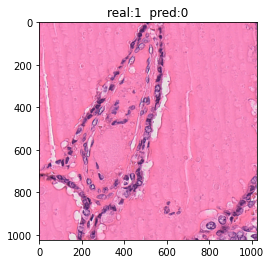

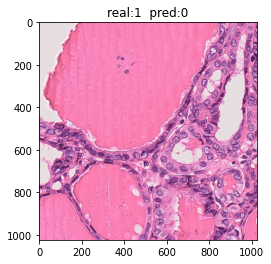

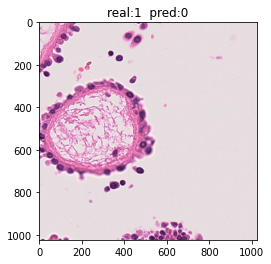

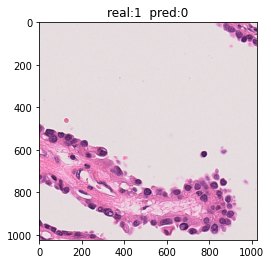

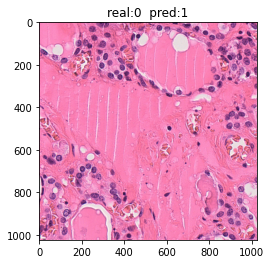

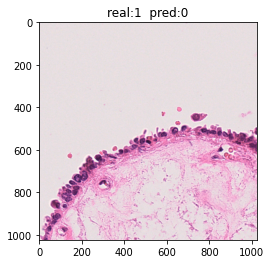

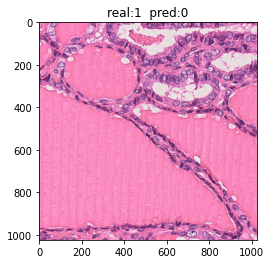

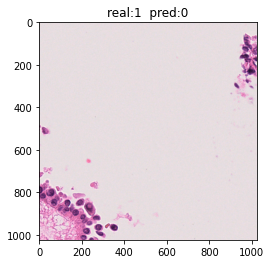

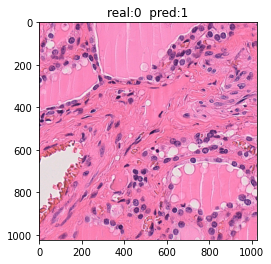

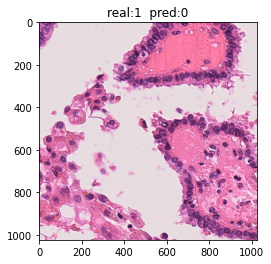

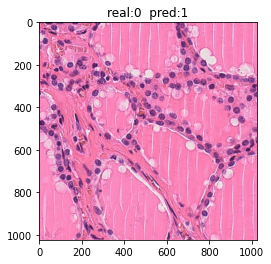

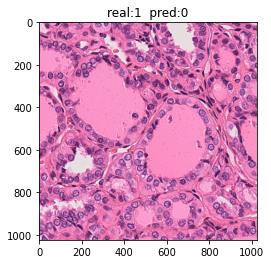

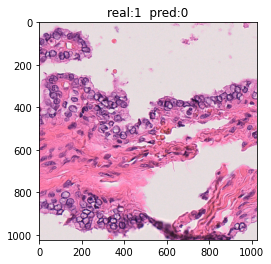

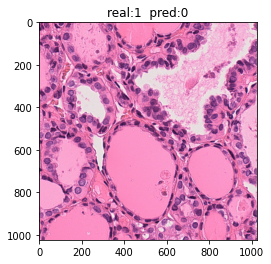

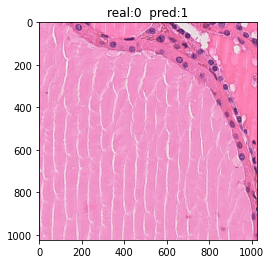

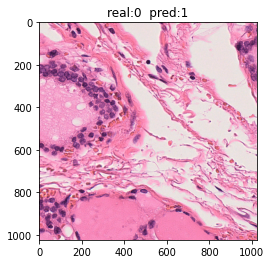

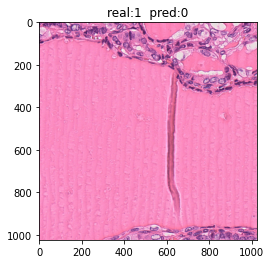

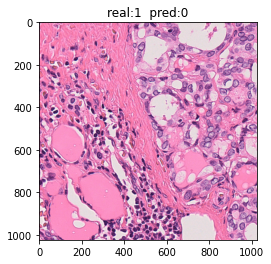

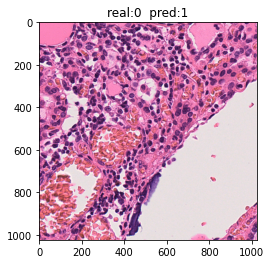

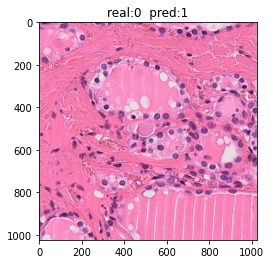

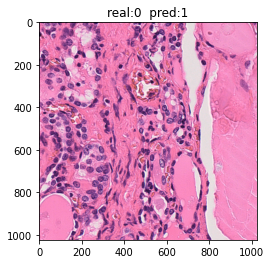

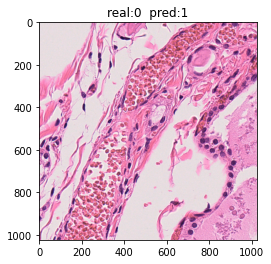

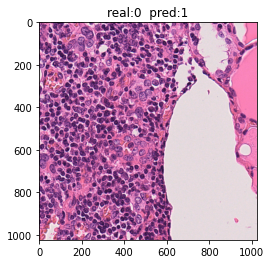

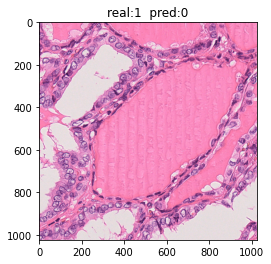

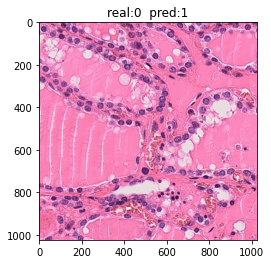

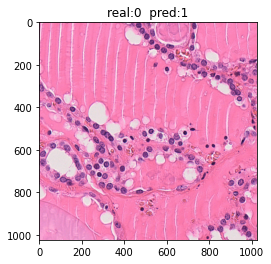

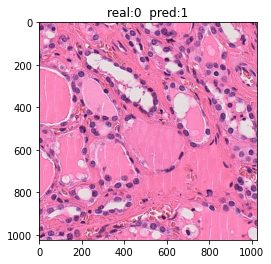

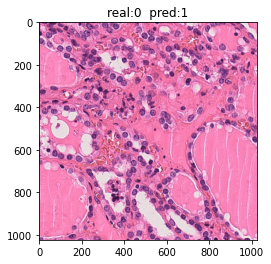

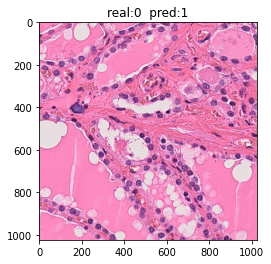

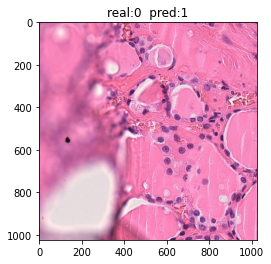

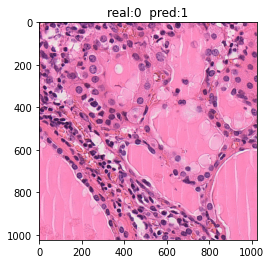

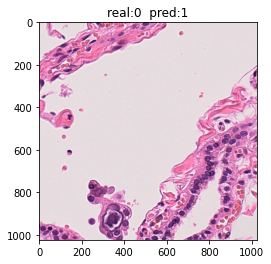

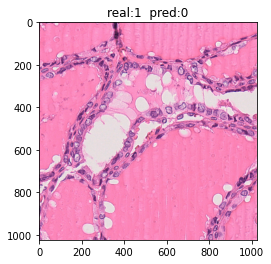

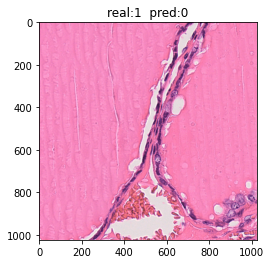

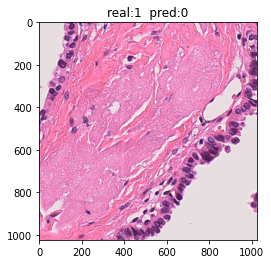

In [44]:
show_wrong_img(dataset, ys, ypreds, val_indices_after_skf)

### テスト用データの識別

In [31]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [32]:
data_path = "./data/"
target_list = ["Normal", "PTC HE", "UN", "fvptc", "FTC", "med", "poor", "und"]

train_list = make_datapath_list(data_path+"train")
test_list = make_datapath_list(data_path+"test")

train_dataset = ArrangeNumDataset(train_list, 
                                  target_list, 
                                  transform=transformer["train"], 
                                  arrange=None)
test_dataset = ArrangeNumDataset(test_list, 
                                 target_list, 
                                 transform=transformer["val"], 
                                 arrange=None)

batch_size = 32
num_workers = 8
only_fc = False    # 転移学習：True, FineTuning：False
pretrained = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers)

./data/train/**/*.tif
./data/test/**/*.tif
使用デバイス： cuda:0


In [33]:
train_num = np.bincount(np.array(train_dataset.targets))
test_num = np.bincount(np.array(test_dataset.targets))
train_num_sum = train_num.sum()
print("train_num:", train_num)
print("train_num_sum:", train_num_sum)
print("test_num:", test_num)
weights = []
for n in train_num:
    weights.append(train_num_sum / n)
    
weights = torch.tensor(weights).float().cuda()
loss_fn=nn.CrossEntropyLoss(weight=weights)
print(loss_fn.weight)

train_num: [3511 1180   96  155  157  100  116  241]
train_num_sum: 5556
test_num: [180 507 214 153 155  21 100 220]
tensor([ 1.5825,  4.7085, 57.8750, 35.8452, 35.3885, 55.5600, 47.8966, 23.0539],
       device='cuda:0')


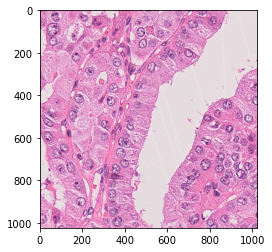

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


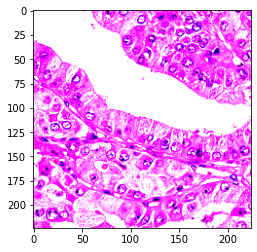

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


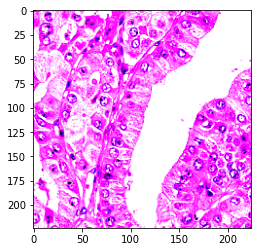

In [34]:
img_path = test_list[100]
show_transform_img(img_path)

In [ ]:
net = init_net(only_fc=only_fc, pretrained=pretrained)

train_net(net, train_loader, test_loader, only_fc=only_fc,
          epochs=30, device=device, loss_fn=loss_fn)
print("訓練完了")

100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:1/30  train_loss: 2.671  train_acc: 0.484  val_acc: 0.199


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:2/30  train_loss: 2.307  train_acc: 0.537  val_acc: 0.381


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:3/30  train_loss: 1.778  train_acc: 0.701  val_acc: 0.355


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:4/30  train_loss: 1.529  train_acc: 0.761  val_acc: 0.506


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:5/30  train_loss: 1.484  train_acc: 0.774  val_acc: 0.531


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:6/30  train_loss: 1.314  train_acc: 0.850  val_acc: 0.493


100%|██████████| 174/174 [01:27<00:00,  2.00it/s]


epoch:7/30  train_loss: 1.377  train_acc: 0.845  val_acc: 0.517


100%|██████████| 174/174 [01:30<00:00,  1.93it/s]


epoch:8/30  train_loss: 1.408  train_acc: 0.824  val_acc: 0.498


100%|██████████| 174/174 [01:30<00:00,  1.93it/s]


epoch:9/30  train_loss: 1.443  train_acc: 0.831  val_acc: 0.354


100%|██████████| 174/174 [01:30<00:00,  1.93it/s]


epoch:10/30  train_loss: 1.436  train_acc: 0.811  val_acc: 0.365


100%|██████████| 174/174 [01:28<00:00,  1.97it/s]


epoch:11/30  train_loss: 1.384  train_acc: 0.832  val_acc: 0.432


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:12/30  train_loss: 1.315  train_acc: 0.852  val_acc: 0.547


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:13/30  train_loss: 1.250  train_acc: 0.883  val_acc: 0.646


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:14/30  train_loss: 1.270  train_acc: 0.862  val_acc: 0.546


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:15/30  train_loss: 1.390  train_acc: 0.838  val_acc: 0.563


100%|██████████| 174/174 [01:26<00:00,  2.01it/s]


epoch:16/30  train_loss: 1.326  train_acc: 0.848  val_acc: 0.533


100%|██████████| 174/174 [01:24<00:00,  2.05it/s]


epoch:17/30  train_loss: 1.221  train_acc: 0.881  val_acc: 0.628


100%|██████████| 174/174 [01:25<00:00,  2.04it/s]


epoch:18/30  train_loss: 1.257  train_acc: 0.883  val_acc: 0.610


100%|██████████| 174/174 [01:25<00:00,  2.04it/s]


epoch:19/30  train_loss: 1.239  train_acc: 0.894  val_acc: 0.495


100%|██████████| 174/174 [01:25<00:00,  2.04it/s]


epoch:20/30  train_loss: 1.217  train_acc: 0.891  val_acc: 0.617


100%|██████████| 174/174 [01:25<00:00,  2.04it/s]


epoch:21/30  train_loss: 1.223  train_acc: 0.913  val_acc: 0.596


100%|██████████| 174/174 [01:25<00:00,  2.04it/s]


epoch:22/30  train_loss: 1.262  train_acc: 0.906  val_acc: 0.195


 16%|█▌        | 27/174 [00:13<01:12,  2.04it/s]

In [ ]:
net = init_net()
load_path = "weight/last_weight.pth"
load_weights = torch.load(load_path)
net.load_state_dict(load_weights)
net = net.to(device)

In [ ]:
ys, ypreds = eval_net(net, test_loader, device=device)
ys = ys.cpu().numpy()
ypreds = ypreds.cpu().numpy()
print(accuracy_score(ys, ypreds))
print(confusion_matrix(ys, ypreds))
print(classification_report(ys, ypreds,
                            target_names=target_list,
                            digits=3))

### undrersampling + baggingimg

In [14]:
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

In [15]:
batch_size = 256
num_workers = 4
only_fc = True    # 転移学習：True, FineTuning：False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("使用デバイス：", device)
data_path = "./data/"
target_list = ["Normal", "PTC HE", "UN", "fvptc", "FTC", "med", "poor", "und"]

train_list = make_datapath_list(data_path+"train")
test_list = make_datapath_list(data_path+"test")

test_dataset = ArrangeNumDataset(test_list,
                                 target_list,
                                 transform=transformer["val"],
                                 arrange=None)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                         num_workers=num_workers, pin_memory=True)

使用デバイス： cuda:0
./data/train/**/*.tif
./data/test/**/*.tif


In [16]:
n_estimators = 5
last_weights = []
best_weights = []
for i in range(n_estimators):
    print("{}/{}".format(i+1, n_estimators))
    train_dataset = ArrangeNumDataset(train_list, 
                                      target_list, 
                                      transform=transformer["train"], 
                                      arrange="undersampling")
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                              num_workers=num_workers, pin_memory=True)
    net = init_net(only_fc=only_fc)
    train_net(net, train_loader, test_loader, epochs=15,
              device=device, only_fc=only_fc)
    last_weights.append(torch.load("weight/last_weight.pth"))
    best_weights.append(torch.load("weight/best_weight.pth"))

1/5


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


epoch:1/15  train_loss: 3.919  train_acc: 0.236  val_acc: 0.369


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


epoch:2/15  train_loss: 3.224  train_acc: 0.672  val_acc: 0.379


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


epoch:3/15  train_loss: 2.673  train_acc: 0.852  val_acc: 0.426


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:4/15  train_loss: 2.273  train_acc: 0.895  val_acc: 0.594


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:5/15  train_loss: 2.002  train_acc: 0.892  val_acc: 0.623


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:6/15  train_loss: 1.794  train_acc: 0.917  val_acc: 0.613


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:7/15  train_loss: 1.667  train_acc: 0.928  val_acc: 0.625


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:8/15  train_loss: 1.574  train_acc: 0.921  val_acc: 0.629


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:9/15  train_loss: 1.506  train_acc: 0.931  val_acc: 0.632


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:10/15  train_loss: 1.467  train_acc: 0.926  val_acc: 0.634


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:11/15  train_loss: 1.428  train_acc: 0.932  val_acc: 0.634


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


epoch:12/15  train_loss: 1.393  train_acc: 0.944  val_acc: 0.637


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:13/15  train_loss: 1.365  train_acc: 0.951  val_acc: 0.639


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:14/15  train_loss: 1.343  train_acc: 0.939  val_acc: 0.643


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


epoch:15/15  train_loss: 1.330  train_acc: 0.952  val_acc: 0.639
Best val Acc: 0.6425806879997253
Last val Acc: 0.6393548846244812
2/5


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:1/15  train_loss: 3.987  train_acc: 0.158  val_acc: 0.354


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


epoch:2/15  train_loss: 3.234  train_acc: 0.652  val_acc: 0.335


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:3/15  train_loss: 2.685  train_acc: 0.837  val_acc: 0.478


100%|██████████| 3/3 [00:04<00:00,  1.66s/it]


epoch:4/15  train_loss: 2.252  train_acc: 0.885  val_acc: 0.599


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:5/15  train_loss: 1.972  train_acc: 0.914  val_acc: 0.622


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


epoch:6/15  train_loss: 1.767  train_acc: 0.932  val_acc: 0.608


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:7/15  train_loss: 1.649  train_acc: 0.918  val_acc: 0.604


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


epoch:8/15  train_loss: 1.554  train_acc: 0.931  val_acc: 0.629


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:9/15  train_loss: 1.488  train_acc: 0.934  val_acc: 0.630


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch:10/15  train_loss: 1.452  train_acc: 0.932  val_acc: 0.631


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


epoch:11/15  train_loss: 1.405  train_acc: 0.943  val_acc: 0.639


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:12/15  train_loss: 1.385  train_acc: 0.939  val_acc: 0.629


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:13/15  train_loss: 1.366  train_acc: 0.940  val_acc: 0.639


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:14/15  train_loss: 1.337  train_acc: 0.941  val_acc: 0.639


100%|██████████| 3/3 [00:04<00:00,  1.65s/it]


epoch:15/15  train_loss: 1.323  train_acc: 0.947  val_acc: 0.635
Best val Acc: 0.6387097239494324
Last val Acc: 0.6354839205741882
3/5


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:1/15  train_loss: 3.792  train_acc: 0.378  val_acc: 0.174


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:2/15  train_loss: 3.093  train_acc: 0.721  val_acc: 0.444


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


epoch:3/15  train_loss: 2.543  train_acc: 0.872  val_acc: 0.584


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:4/15  train_loss: 2.169  train_acc: 0.901  val_acc: 0.588


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:5/15  train_loss: 1.921  train_acc: 0.900  val_acc: 0.603


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


epoch:6/15  train_loss: 1.747  train_acc: 0.915  val_acc: 0.639


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:7/15  train_loss: 1.633  train_acc: 0.914  val_acc: 0.618


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch:8/15  train_loss: 1.551  train_acc: 0.921  val_acc: 0.625


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


epoch:9/15  train_loss: 1.489  train_acc: 0.928  val_acc: 0.644


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


epoch:10/15  train_loss: 1.453  train_acc: 0.927  val_acc: 0.644


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


epoch:11/15  train_loss: 1.415  train_acc: 0.936  val_acc: 0.638


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:12/15  train_loss: 1.393  train_acc: 0.935  val_acc: 0.645


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:13/15  train_loss: 1.355  train_acc: 0.947  val_acc: 0.655


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:14/15  train_loss: 1.349  train_acc: 0.936  val_acc: 0.657


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:15/15  train_loss: 1.335  train_acc: 0.939  val_acc: 0.654
Best val Acc: 0.6567742228507996
Last val Acc: 0.6535484194755554
4/5


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:1/15  train_loss: 3.960  train_acc: 0.160  val_acc: 0.330


100%|██████████| 3/3 [00:05<00:00,  1.80s/it]


epoch:2/15  train_loss: 3.260  train_acc: 0.596  val_acc: 0.281


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:3/15  train_loss: 2.718  train_acc: 0.842  val_acc: 0.529


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:4/15  train_loss: 2.320  train_acc: 0.893  val_acc: 0.621


100%|██████████| 3/3 [00:05<00:00,  1.70s/it]


epoch:5/15  train_loss: 2.044  train_acc: 0.904  val_acc: 0.608


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:6/15  train_loss: 1.836  train_acc: 0.922  val_acc: 0.615


100%|██████████| 3/3 [00:05<00:00,  1.74s/it]


epoch:7/15  train_loss: 1.686  train_acc: 0.924  val_acc: 0.630


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


epoch:8/15  train_loss: 1.615  train_acc: 0.923  val_acc: 0.654


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:9/15  train_loss: 1.531  train_acc: 0.936  val_acc: 0.637


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:10/15  train_loss: 1.477  train_acc: 0.936  val_acc: 0.631


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


epoch:11/15  train_loss: 1.452  train_acc: 0.931  val_acc: 0.650


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


epoch:12/15  train_loss: 1.397  train_acc: 0.945  val_acc: 0.663


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:13/15  train_loss: 1.376  train_acc: 0.949  val_acc: 0.661


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:14/15  train_loss: 1.357  train_acc: 0.944  val_acc: 0.639


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:15/15  train_loss: 1.350  train_acc: 0.944  val_acc: 0.658
Best val Acc: 0.662580668926239
Last val Acc: 0.6580645442008972
5/5


100%|██████████| 3/3 [00:05<00:00,  1.68s/it]


epoch:1/15  train_loss: 3.890  train_acc: 0.297  val_acc: 0.354


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch:2/15  train_loss: 3.108  train_acc: 0.784  val_acc: 0.301


100%|██████████| 3/3 [00:05<00:00,  1.67s/it]


epoch:3/15  train_loss: 2.530  train_acc: 0.861  val_acc: 0.605


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:4/15  train_loss: 2.143  train_acc: 0.880  val_acc: 0.603


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:5/15  train_loss: 1.877  train_acc: 0.893  val_acc: 0.596


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


epoch:6/15  train_loss: 1.711  train_acc: 0.902  val_acc: 0.600


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:7/15  train_loss: 1.590  train_acc: 0.913  val_acc: 0.615


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:8/15  train_loss: 1.506  train_acc: 0.917  val_acc: 0.615


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:9/15  train_loss: 1.458  train_acc: 0.938  val_acc: 0.635


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:10/15  train_loss: 1.420  train_acc: 0.940  val_acc: 0.633


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:11/15  train_loss: 1.401  train_acc: 0.928  val_acc: 0.637


100%|██████████| 3/3 [00:05<00:00,  1.72s/it]


epoch:12/15  train_loss: 1.360  train_acc: 0.945  val_acc: 0.637


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:13/15  train_loss: 1.353  train_acc: 0.941  val_acc: 0.647


100%|██████████| 3/3 [00:05<00:00,  1.69s/it]


epoch:14/15  train_loss: 1.324  train_acc: 0.944  val_acc: 0.649


100%|██████████| 3/3 [00:05<00:00,  1.73s/it]


epoch:15/15  train_loss: 1.325  train_acc: 0.941  val_acc: 0.651
Best val Acc: 0.6509677767753601
Last val Acc: 0.6509677767753601


In [17]:
net = init_net(only_fc=only_fc)
ypreds_vote = []
for weight in last_weights:  # last_weight or best_weight
    net.load_state_dict(weight)
    net = net.to(device)
    ys, ypreds = eval_net(net, test_loader, device=device)
    ypreds = ypreds.cpu().numpy()
    ypreds_vote.append(ypreds)

ypreds_vote, count = scipy.stats.mode(ypreds_vote, axis=0)
ypreds_vote = ypreds_vote.ravel()
ys = ys.cpu().numpy()
print(accuracy_score(ys, ypreds_vote))
print(confusion_matrix(ys, ypreds_vote))
print(classification_report(ys, ypreds_vote,
                            target_names=target_list,
                            digits=3))

0.6503225806451612
[[178   1   1   0   0   0   0   0]
 [ 24 437  31   1   0   3   1  10]
 [ 63  64  87   0   0   0   0   0]
 [  4  38   9   0  37   3   0  62]
 [  0  99  28   0   4   0   1  23]
 [  0   0   0   0   0  21   0   0]
 [  0   1   0   0   0   0  99   0]
 [  0  29   0   2   2   5   0 182]]
              precision    recall  f1-score   support

      Normal      0.662     0.989     0.793       180
      PTC HE      0.653     0.862     0.743       507
          UN      0.558     0.407     0.470       214
       fvptc      0.000     0.000     0.000       153
         FTC      0.093     0.026     0.040       155
         med      0.656     1.000     0.792        21
        poor      0.980     0.990     0.985       100
         und      0.657     0.827     0.732       220

    accuracy                          0.650      1550
   macro avg      0.532     0.638     0.570      1550
weighted avg      0.542     0.650     0.582      1550



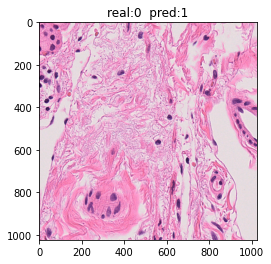

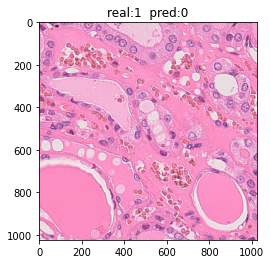

In [40]:
test_dataset_not_transform = ImageFolder(data_path + "test")

show_wrong_img(test_dataset_not_transform, ys, ypreds_vote)